In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
from skimage.transform import resize, rescale, rotate, setup, warp
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.patches as patches

from skimage.color import rgb2gray

import PIL
from PIL import Image

from google.colab import output

from sklearn.linear_model import LinearRegression

In [2]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

/content
Cloning into 'Lithuanian_OCR'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 4193 (delta 20), reused 36 (delta 13), pack-reused 4148
Receiving objects: 100% (4193/4193), 384.44 MiB | 31.98 MiB/s, done.
Resolving deltas: 100% (681/681), done.
Checking out files: 100% (797/797), done.


In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)     
        out = self.fc3(out)
        return out

In [4]:
networks = []
batches = os.listdir('/content/Lithuanian_OCR/Trained_model')

for batch in batches:
  if(batch != 'treshold.txt' and batch != '.ipynb_checkpoints'):
    nt = Net(4096, 1500, 300, 3)

    nt.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/' + batch + '/model.pth'))
    nt.eval()

    networks.append(nt)

print("Loaded {} networks".format(len(networks)))

treshold = []

with open('/content/Lithuanian_OCR/Trained_model/treshold.txt') as fp:
   line = fp.readline()
   cnt = 0
   while line:
       treshold.append(line.strip().split(' ')[1])
       line = fp.readline()
       cnt += 1

if(len(treshold) != len(networks)):
  print('ERROR LOADING TRESHOLDS!')

Loaded 2 networks


In [0]:
def proccess_image(path):
  image = io.imread(path)
  image = rgb2gray(image)
  image = resize(image, (64, 64))
  
  return torch.tensor(image)

def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

def get_result(data):
  idx = get_max_from_tensor(data) - 1

  if(data[idx] > 6):
    return idx + 1
  # No object found
  elif(data[idx] <= 6):
    return 0
  # Best guess is that there is no object
  else:
    return 0

def find_in_array(arr, element):
  idx = 0
  found = []

  for el in arr:
    if(el == element):
      found.append(idx)
    idx += 1

  return found

def prepare_image_for_network(image):
  image = resize(image, (64, 64))

  return image

def parse_letters(letter_idx, network_idx):
  if(network_idx == 0):
    switcher = {
        1: 'A',
        2: 'B',
        3: 'C'
    }
  elif(network_idx == 1):
        switcher = {
        1: 'a',
        2: 'P',
        3: 'u'
    }

  return switcher.get(letter_idx)

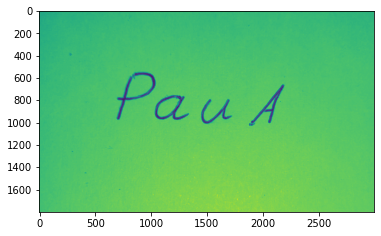

In [36]:
image = io.imread('/content/Lithuanian_OCR/Examples/example3.jpg')

# image = rotate(image, 90)
image = rgb2gray(image)
image = resize(image, (1800, 3000))
plt.imshow(image)

Searching color distances...
Sorting by y...
Removing far point by x axis
Sorting by x...
Removing far point by x axis


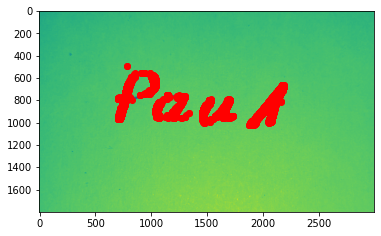

4267


In [37]:
registered_x = []
registered_y = []

print("Searching color distances...")
for y in range(image.shape[0]):
  last_val = image[y][0]
  for x in range(image.shape[1]):
    if(abs(last_val - image[y][x]) >= 0.1):
      registered_x.append(x)
      registered_y.append(y)
    last_val = image[y][x]

# Sorting points by y
print("Sorting by y...")
sorted = False
while(sorted == False):
  sorted = True
  for i in range(len(registered_y)-1):
    if(registered_y[i] > registered_y[i+1]):
      sorted = False
      buffX = registered_x[i]
      buffY = registered_y[i]

      registered_x[i] = registered_x[i+1]
      registered_y[i] = registered_y[i+1]

      registered_x[i+1] = buffX
      registered_y[i+1] = buffY

# Filter points that are far away from each other
print("Removing far point by x axis")
removed = True
while(removed == True):
  removed = False
  buffer_x = []
  buffer_y = []
  distance_treshold = 200
  for i in range(len(registered_y)-1):
    if(i != len(registered_y)-1):
      if(abs(registered_y[i+1] - registered_y[i]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True
    else:
      if(abs(registered_y[i] - registered_y[i-1]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True

  registered_x = buffer_x
  registered_y = buffer_y
  
# Sorting points by x
print("Sorting by x...")
sorted = False
while(sorted == False):
  sorted = True
  for i in range(len(registered_x)-1):
    if(registered_x[i] > registered_x[i+1]):
      sorted = False
      buffX = registered_x[i]
      buffY = registered_y[i]

      registered_x[i] = registered_x[i+1]
      registered_y[i] = registered_y[i+1]

      registered_x[i+1] = buffX
      registered_y[i+1] = buffY

# Filter points that are far away from each other
print("Removing far point by x axis")
removed = True
while(removed == True):
  removed = False
  buffer_x = []
  buffer_y = []
  distance_treshold = 200
  for i in range(len(registered_x)-1):
    if(i != len(registered_x)-1):
      if(abs(registered_x[i+1] - registered_x[i]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True
    else:
      if(abs(registered_x[i] - registered_x[i-1]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True

  registered_x = buffer_x
  registered_y = buffer_y

implot = plt.imshow(image)
plt.scatter(registered_x, registered_y, c='r')
plt.show()

print(len(registered_x))

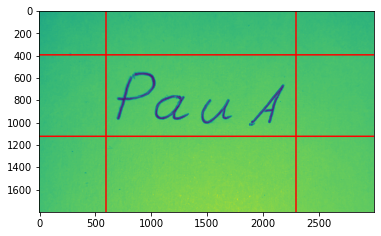

In [38]:
margins = 100

# Finding lowest y point
lowest_y = registered_y[0]
lowest_x = registered_x[0]

highest_y = registered_y[0]
highest_x = registered_x[0]

for i in range(len(registered_x)):
  if(registered_y[i] > highest_y):
    highest_x = registered_x[i]
    highest_y = registered_y[i]

  if(registered_y[i] < lowest_y):
    lowest_x = registered_x[i]
    lowest_y = registered_y[i]

# Finding smallest x point
smallest_x = registered_x[0]
smallest_y = registered_y[0]

biggest_x = registered_x[0]
biggest_y = registered_y[0]

for i in range(len(registered_x)):
  if(registered_x[i] > biggest_x):
    biggest_x = registered_x[i]
    biggest_y = registered_y[i]

  if(registered_x[i] < smallest_x):
    smallest_x = registered_x[i]
    smallest_y = registered_y[i]

implot = plt.imshow(image)
plt.plot(np.arange(0, image.shape[1], 1), np.repeat(highest_y+margins, image.shape[1]), c='r')
plt.plot(np.arange(0, image.shape[1], 1), np.repeat(lowest_y-margins, image.shape[1]), c='r')
plt.axvline(smallest_x-margins, c='r')
plt.axvline(biggest_x+margins, c='r')
plt.show()

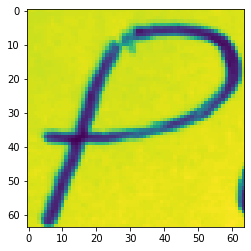

tensor([-10.3265,  -9.9544,  -9.0095], grad_fn=<AddBackward0>)
tensor([-12.6550,  12.4247, -12.5912], grad_fn=<AddBackward0>)
P


In [39]:
img = image[516:975, 672:1050]
# img = image[736:998, 1056:1381]
# img = image[771:1016, 1475:1781]
img = resize(img, (64, 64))
plt.imshow(img)
plt.show()

maxProb = 0
network_idx = 0
MaxRes = 0
for t in range(len(networks)):
  output = networks[t](torch.Tensor(img).flatten().float())
  res = get_result(output)
  prob = output[res - 1]

  print(output)

  if(prob > maxProb):
    maxProb = prob
    network_idx = t
    MaxRes = res

print(parse_letters(MaxRes, network_idx))

In [42]:
letters = []
stepSize = 10

lastRes = 0

picture_start_point = 0
for i in range(int(image.shape[1]/stepSize)):
  img = image[(lowest_y-margins):(highest_y+margins), (picture_start_point):(i*stepSize)]

  if(img.shape[0] > 0 and img.shape[1] > 0):
    reshaped_img = resize(img, (64, 64))

    for idx in range(len(networks)):
      output = networks[idx](torch.Tensor(reshaped_img).flatten().float())
      
      res = get_max_from_tensor(output)

      if(res != lastRes):
        lastRes = res
        picture_start_point = i*stepSize

      if(float(output[res - 1]) > float(treshold[idx])):
        if(parse_letters(res - 1, idx) != None and output[res - 1] > 0):
          print("Result: {} Prob: {}".format(parse_letters(res - 1, idx), output[res - 1]))
          letters.append(parse_letters(res - 1, idx))

Result: a Prob: 4.431076526641846
Result: a Prob: 3.5530948638916016
Result: a Prob: 2.2326083183288574
Result: P Prob: 9.864423751831055
Result: P Prob: 13.686092376708984
Result: P Prob: 13.240840911865234
Result: A Prob: 2.2905325889587402
Result: P Prob: 6.619231224060059
Result: P Prob: 12.65267562866211
Result: A Prob: 3.058610677719116
Result: A Prob: 6.896749496459961
Result: P Prob: 2.9854626655578613
Result: P Prob: 5.6965813636779785
Result: a Prob: 1.6322875022888184
Result: a Prob: 3.7638630867004395
Result: a Prob: 1.0664746761322021
Result: a Prob: 1.5977295637130737
Result: a Prob: 1.8449196815490723


In [43]:
# Removing duplicates from array
answer = []
last_letter = ""
for x in letters:
  if last_letter == "" and x != None:
    last_letter = x
    answer.append(x)
  else:
    if(x != last_letter and x != None):
      last_letter = x
      answer.append(x)

print(answer)

['a', 'P', 'A', 'P', 'A', 'P', 'a']


# Kitas pavyzdys

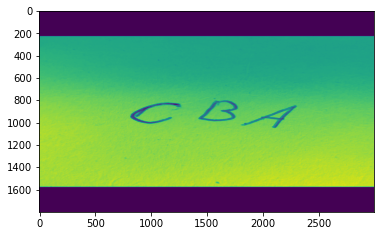

In [44]:
image = io.imread('/content/Lithuanian_OCR/Examples/example2.jpg')
image = rotate(image, 90)
image = rgb2gray(image)
image = resize(image, (1800, 3000))
plt.imshow(image)

Searching color distances...
X length: 206 Y length: 206
Sorting by y...
Removing far point by x axis
Sorting by x...
Removing far point by x axis


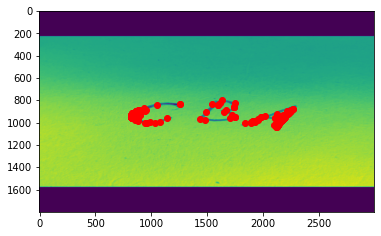

201


In [45]:
registered_x = []
registered_y = []

print("Searching color distances...")
for y in range(image.shape[0]):
  last_val = image[y][0]
  for x in range(image.shape[1]):
    if(abs(last_val - image[y][x]) >= 0.08):
      registered_x.append(x)
      registered_y.append(y)
    last_val = image[y][x]

print("X length: {} Y length: {}".format(len(registered_x), len(registered_y)))

# Sorting points by y
print("Sorting by y...")
sorted = False
while(sorted == False):
  sorted = True
  for i in range(len(registered_y)-1):
    if(registered_y[i] > registered_y[i+1]):
      sorted = False
      buffX = registered_x[i]
      buffY = registered_y[i]

      registered_x[i] = registered_x[i+1]
      registered_y[i] = registered_y[i+1]

      registered_x[i+1] = buffX
      registered_y[i+1] = buffY

# Filter points that are far away from each other
print("Removing far point by x axis")
removed = True
while(removed == True):
  removed = False
  buffer_x = []
  buffer_y = []
  distance_treshold = 200
  for i in range(len(registered_y)-1):
    if(i != len(registered_y)-1):
      if(abs(registered_y[i+1] - registered_y[i]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True
    else:
      if(abs(registered_y[i] - registered_y[i-1]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True

  registered_x = buffer_x
  registered_y = buffer_y
  
# Sorting points by x
print("Sorting by x...")
sorted = False
while(sorted == False):
  sorted = True
  for i in range(len(registered_x)-1):
    if(registered_x[i] > registered_x[i+1]):
      sorted = False
      buffX = registered_x[i]
      buffY = registered_y[i]

      registered_x[i] = registered_x[i+1]
      registered_y[i] = registered_y[i+1]

      registered_x[i+1] = buffX
      registered_y[i+1] = buffY

# Filter points that are far away from each other
print("Removing far point by x axis")
removed = True
while(removed == True):
  removed = False
  buffer_x = []
  buffer_y = []
  distance_treshold = 200
  for i in range(len(registered_x)-1):
    if(i != len(registered_x)-1):
      if(abs(registered_x[i+1] - registered_x[i]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True
    else:
      if(abs(registered_x[i] - registered_x[i-1]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True

  registered_x = buffer_x
  registered_y = buffer_y

implot = plt.imshow(image)
plt.scatter(registered_x, registered_y, c='r')
plt.show()

print(len(registered_x))

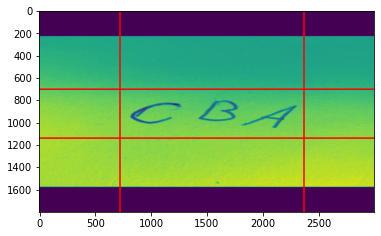

In [46]:
margins = 100

# Finding lowest y point
lowest_y = registered_y[0]
lowest_x = registered_x[0]

highest_y = registered_y[0]
highest_x = registered_x[0]

for i in range(len(registered_x)):
  if(registered_y[i] > highest_y):
    highest_x = registered_x[i]
    highest_y = registered_y[i]

  if(registered_y[i] < lowest_y):
    lowest_x = registered_x[i]
    lowest_y = registered_y[i]

# Finding smallest x point
smallest_x = registered_x[0]
smallest_y = registered_y[0]

biggest_x = registered_x[0]
biggest_y = registered_y[0]

for i in range(len(registered_x)):
  if(registered_x[i] > biggest_x):
    biggest_x = registered_x[i]
    biggest_y = registered_y[i]

  if(registered_x[i] < smallest_x):
    smallest_x = registered_x[i]
    smallest_y = registered_y[i]

implot = plt.imshow(image)
plt.plot(np.arange(0, image.shape[1], 1), np.repeat(highest_y+margins, image.shape[1]), c='r')
plt.plot(np.arange(0, image.shape[1], 1), np.repeat(lowest_y-margins, image.shape[1]), c='r')
plt.axvline(smallest_x-margins, c='r')
plt.axvline(biggest_x+margins, c='r')
plt.show()

In [47]:
letters = []
stepSize = 2

lastRes = 0

picture_start_point = 0
for i in range(int(image.shape[1]/stepSize)):
  img = image[(lowest_y-margins):(highest_y+margins), (picture_start_point):(i*stepSize)]

  if(img.shape[0] > 0 and img.shape[1] > 0):
    reshaped_img = resize(img, (64, 64))

    for idx in range(len(networks)):
      output = networks[idx](torch.Tensor(reshaped_img).flatten().float())
      
      res = get_max_from_tensor(output)

      if(res != lastRes):
        lastRes = res
        picture_start_point = i*stepSize

      if(float(output[res - 1]) > float(treshold[idx])):
        if(parse_letters(res - 1, idx) != None and output[res - 1] > 0):
          print("Result: {} Prob: {}".format(parse_letters(res - 1, idx), output[res - 1]))
          letters.append(parse_letters(res - 1, idx))

Result: a Prob: 0.6997973918914795
Result: a Prob: 2.083331346511841
Result: a Prob: 3.1486480236053467
Result: a Prob: 2.90301251411438
Result: a Prob: 2.8589155673980713
Result: a Prob: 2.5866427421569824
Result: a Prob: 2.405557155609131
Result: a Prob: 2.9200358390808105
Result: a Prob: 3.1176726818084717
Result: a Prob: 3.2588884830474854
Result: a Prob: 3.1462178230285645
Result: a Prob: 3.4061079025268555
Result: a Prob: 3.3760621547698975
Result: a Prob: 3.232062339782715
Result: a Prob: 3.509014844894409
Result: a Prob: 3.4323792457580566
Result: a Prob: 3.161638021469116
Result: a Prob: 2.8591716289520264
Result: a Prob: 2.4717066287994385
Result: a Prob: 1.7837634086608887
Result: a Prob: 1.1348381042480469
Result: a Prob: 1.4416136741638184
Result: a Prob: 1.7967703342437744
Result: a Prob: 2.1122188568115234
Result: a Prob: 2.6699752807617188
Result: a Prob: 3.0741586685180664
Result: a Prob: 3.2124078273773193
Result: a Prob: 3.421858787536621
Result: a Prob: 3.1177692413

In [48]:
# Removing duplicates from array
answer = []
last_letter = ""
for x in letters:
  if last_letter == "" and x != None:
    last_letter = x
    answer.append(x)
  else:
    if(x != last_letter and x != None):
      last_letter = x
      answer.append(x)

print(answer)

['a']
